In [3]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/drive


In [2]:
!nvidia-smi

Fri May 14 19:51:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%%capture
!git clone https://github.com/davidtvs/pytorch-lr-finder.git && cd pytorch-lr-finder && python setup.py install

In [1]:
%%capture
!pip install transformers
!pip install pytorch_lightning

In [2]:
%%capture
!pip install tokenizers

In [3]:
import numpy as np 
import pandas as pd 

import os
import re
import time
import datetime
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from collections import Counter, defaultdict

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from transformers import RobertaModel, RobertaTokenizerFast
from transformers import RobertaForSequenceClassification, RobertaConfig
from transformers import RobertaForMaskedLM

import torch
from torch import nn, optim
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler

from typing import List
import torch.nn.functional as F
import logging
import os
from functools import lru_cache
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from argparse import Namespace
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
torch.__version__

'1.8.1+cu101'

In [4]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

In [5]:
## emotion labels
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

config = RobertaConfig.from_pretrained('roberta-base')
config.num_labels = len(list(label2int.values()))
config

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [6]:
class SentimentModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            # Mish(),
            # nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)
        
        # maybe do some pooling / RNNs... go crazy here!
        
        # use the <s> representation
        return self.classifier(hidden_states[0][:, 0, :])

In [7]:
# from https://github.com/digantamisra98/Mish/blob/b5f006660ac0b4c46e2c6958ad0301d7f9c59651/Mish/Torch/mish.py
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))
  
class Mish(nn.Module):
    def forward(self, input):
        return mish(input)

In [9]:
#classifier = SentimentModel(RobertaForSequenceClassification(config).base_model, 6)

classifier = SentimentModel(RobertaForMaskedLM.from_pretrained('roberta-base').base_model, 6)
classifier

SentimentModel(
  (base_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [64]:
!ls

drive		     merged_training.pkl.1  sample_data  tokenizer    val.txt
lightning_logs	     notebooks		    test.txt	 train.txt    val.txt.1
merged_training.pkl  pytorch-lr-finder	    test.txt.1	 train.txt.1


In [10]:
!mkdir -p tokenizer

In [11]:

tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [12]:
!ls tokenizer

merges.txt		 tokenizer_config.json	vocab.json
special_tokens_map.json  tokenizer.json


In [13]:
%%capture
!wget https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
!wget https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
!wget https://www.dropbox.com/s/2mzialpsgf9k5l3/val.txt
!wget https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl

In [14]:
import pickle

## helper function
def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

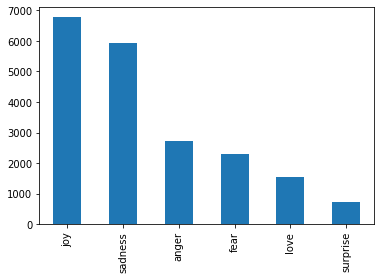

In [15]:
data = load_from_pickle(directory="merged_training.pkl")

## using a sample
emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]
data= data[data["emotions"].isin(emotions)]


data = data.sample(n=20000);

data.emotions.value_counts().plot.bar()

In [16]:
data.count()

text        20000
emotions    20000
dtype: int64

In [17]:
data.head()

,text,emotions
675,the day the results of the certificate exam ca...,fear
21060,i held her breathing her in as if my life depe...,love
109927,im a nice person and if someone feels disturbe...,sadness
32700,i really have no clue where to start but i fee...,fear
13829,i feel out of place looking through your windo...,love


In [18]:
data.reset_index(drop=True, inplace=True)

,text,emotions
0,the day the results of the certificate exam ca...,fear
1,i held her breathing her in as if my life depe...,love
2,im a nice person and if someone feels disturbe...,sadness
3,i really have no clue where to start but i fee...,fear
4,i feel out of place looking through your windo...,love


In [28]:
data

,text,emotions
0,the day the results of the certificate exam ca...,fear
1,i held her breathing her in as if my life depe...,love
2,im a nice person and if someone feels disturbe...,sadness
3,i really have no clue where to start but i fee...,fear
4,i feel out of place looking through your windo...,love
...,...,...
19995,i know homosexuals feel as they struggle to fa...,anger
19996,i feel i was more annoyed in the story than in...,anger
19997,i remember exactly where i was when i heard ab...,surprise
19998,i remember feeling hopeless,sadness


In [21]:
train_path = "train.txt"
test_path = "test.txt"
val_path = "val.txt"

In [22]:
from sklearn.model_selection import train_test_split
import numpy as np

# Creating training and validation sets using an 80-20 split
input_train, input_val, target_train, target_val = train_test_split(data.text.to_numpy(), 
                                                                    data.emotions.to_numpy(), 
                                                                    test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_val, input_test, target_val, target_test = train_test_split(input_val, target_val, test_size=0.5)


## create a dataframe for each dataset
train_dataset = pd.DataFrame(data={"text": input_train, "class": target_train})
val_dataset = pd.DataFrame(data={"text": input_val, "class": target_val})
test_dataset = pd.DataFrame(data={"text": input_test, "class": target_test})
final_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }

train_dataset.to_csv(train_path, sep=";",header=False, index=False)
val_dataset.to_csv(test_path, sep=";",header=False, index=False)
test_dataset.to_csv(val_path, sep=";",header=False, index=False)

In [78]:
class SentimentDataset(Dataset):
  def __init__(self, path):
    super().__init__()
    self.data_column = "text"
    self.class_column = "class"
    self.data = pd.read_csv(path, sep=";", header=None, names=[self.data_column, self.class_column],
                               engine="python")

  def __getitem__(self, idx):
    return self.data.loc[idx, self.data_column], label2int[self.data.loc[idx, self.class_column]]

  def __len__(self):
    return self.data.shape[0]

In [79]:
dataset = SentimentDataset(train_path)

In [80]:
ds = dataset[2]
ds

('i hadnt anticipated happening quite so quickly in this new international life was feeling passionate about honduras',
 2)

In [81]:
class TokenizersCollateFn:
    def __init__(self, max_tokens=512):

        ## RoBERTa uses BPE tokenizer similar to GPT
        t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
        
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding()
        self.tokenizer = t

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])
        
        return (sequences_padded, attention_masks_padded), labels

In [82]:

## Methods required by PyTorchLightning

class Sentiment_Training(pl.LightningModule):
    def __init__(self, tmp):
        super().__init__()
        # self.model = SentimentModel(RobertaForSequenceClassification(config).base_model, len(emotions))
        self.model = SentimentModel(RobertaForMaskedLM.from_pretrained('roberta-base').base_model, len(emotions))
        self.loss = nn.CrossEntropyLoss() ## combines LogSoftmax() and NLLLoss()
        self.hparam = tmp
        
    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        if step_name == "train":
          self.log("loss",loss, on_step=True, on_epoch=True, prog_bar=True)
        else:
          self.log(loss_key, loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparam.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparam.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparam.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    SentimentDataset(ds_path),
                    batch_size=self.hparam.batch_size,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparam.accumulate_grad_batches * self.hparam.epochs

    def configure_optimizers(self):
        ## use AdamW optimizer -- faster approach to training NNs
        ## read: https://www.fast.ai/2018/07/02/adam-weight-decay/
        optimizer = AdamW(self.model.parameters(), lr=self.hparam.lr)
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparam.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.18E-05


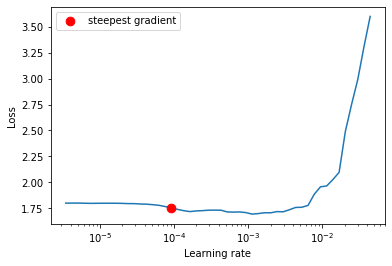

In [84]:
lr=0.1 ## uper bound LR
from torch_lr_finder import LRFinder
hparams_tmp = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=1,
    lr=lr,
    accumulate_grad_batches=1,
)
module = TrainingModule(hparams_tmp)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(module.parameters(), lr=5e-7) ## lower bound LR
lr_finder = LRFinder(module, optimizer, criterion, device="cuda")
lr_finder.range_test(module.train_dataloader(), end_lr=100, num_iter=100, accumulation_steps=hparams_tmp.accumulate_grad_batches)
lr_finder.plot()
lr_finder.reset()

In [85]:
lr = 1E-05
lr

1e-05

LR suggestion: steepest gradient
Suggested LR: 9.18E-05


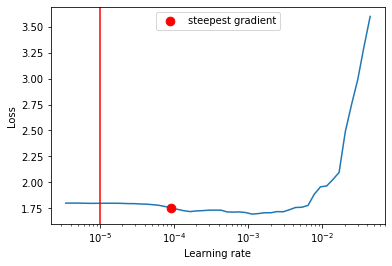

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe579483190>,
 9.180942678743853e-05)

In [86]:
lr_finder.plot(show_lr=lr)

In [88]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=5,
    lr=lr,
    accumulate_grad_batches=1,
)
module = Sentiment_Training(hparams)

In [89]:
import gc; gc.collect()
torch.cuda.empty_cache()

In [90]:

trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs, progress_bar_refresh_rate=10,
                     accumulate_grad_batches=hparams.accumulate_grad_batches,num_sanity_val_steps=0)

history = trainer.fit(module)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | SentimentModel   | 124 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
498.601   Total estimated model params size (MB)


In [91]:

with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.cuda()
    module.eval()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        batch = (X.cuda(), attn.cuda())
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=6))

/
________________________________________________________________________________
              precision    recall  f1-score   support

     sadness   0.984183  0.958904  0.971379       584
         joy   0.963557  0.941595  0.952450       702
        love   0.783784  0.895062  0.835735       162
       anger   0.916981  0.949219  0.932821       256
        fear   0.909524  0.888372  0.898824       215
    surprise   0.858824  0.901235  0.879518        81

    accuracy                       0.936500      2000
   macro avg   0.902809  0.922398  0.911788      2000
weighted avg   0.939006  0.936500  0.937292      2000



In [56]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
def show_confusion_matrix(confusion_matrix):
  hmap = sn.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(true_y, pred_y)

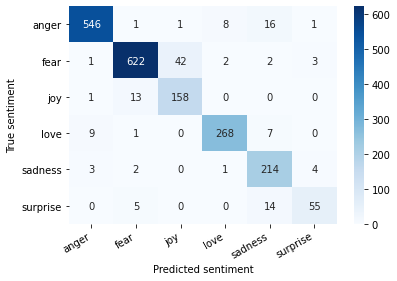

In [58]:
df_cm = pd.DataFrame(cm, index = ["anger", "fear", "joy", "love", "sadness", "surprise"], columns = ["anger", "fear", "joy", "love", "sadness", "surprise"])
show_confusion_matrix(df_cm)

In [59]:
def trim_decoder(tok):
  s = ''
  tok = tok[3:]
  for i, l in enumerate(tok):
    if l == '<':
      break
    if i == 0:
      s+= l.upper()
    else:
      s+=l
  s+='.'
  return s


In [60]:
for i, batch in enumerate(module.test_dataloader()):
  (X, attn),y= batch
  k = (X.cuda(), attn.cuda())
  y_pred = torch.argmax(module(k), dim=1)
  _, pred_label = torch.max(module(k).data, 1)
  for x, p,l in zip(X,pred_label,y):
    print("--"*10)
    print(trim_decoder(tokenizer.decode(x)))
    print("predicted:", list(label2int)[p.item()])
    print("Expected", list(label2int)[l.item()])
    print()
  true_y.extend(y.cpu())
  pred_y.extend(y_pred.cpu())
  
  break

--------------------
I feel that the offender tortured animals when he was a kid he wasnt properly potty trained and proberly owns a pink shirt.
predicted: fear
Expected anger

--------------------
I would show up every once in a while to an empty classroom and just return to my office shrugging my shoulders and feeling somewhat of a guilty pleasure in not having to teach class.
predicted: sadness
Expected sadness

--------------------
I sat down and asked my mind to shut up not feeling particularly hopeful that anything would come of it.
predicted: joy
Expected joy

--------------------
I will attempt porn if you specifically ask for it because i am feeling dangerous.
predicted: anger
Expected anger

--------------------
I am feeling up to it i will publish the next installment of this wonderful horror serial.
predicted: joy
Expected joy

--------------------
I were feeling a bit dull and we were trying to figure out exactly why.
predicted: sadness
Expected sadness

------------------

In [45]:
def get_reply(msg):
  module.cuda()
  model = module.eval() 
  enc = tokenizer.encode_plus(msg)
  X = torch.tensor(enc["input_ids"]).unsqueeze(0).cuda()
  attn = torch.tensor(enc["attention_mask"]).unsqueeze(0).cuda()
  output = module((X,attn))
  _, pred_label = torch.max(output.data, 1)
  prediction=list(label2int.keys())[pred_label.item()]
  print(prediction)

In [46]:
get_reply("Alexa play a romantic on spotify")

love


In [47]:
get_reply("it is rainy in Sao Paulo")

sadness


In [48]:
get_reply("Book tacos for me tonight")

anger


In [49]:
get_reply("i could not stop feeling my hair because it was super soft")

joy


In [50]:
get_reply("i am feeling so blessed today as i spent the entire weekend with our immediate family aka the fockers")

love


In [51]:
get_reply("i am trying my best in life, but I am still lacking in everything that I try to accomplish.")

sadness
